<a href="https://colab.research.google.com/github/marihatabassum/SBP-DATA-Analysis/blob/main/SEGY_file_to_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install segyio
import segyio
from scipy import ndimage as ndi
from shutil import copyfile
from skimage import exposure


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
filename="/content/drive/MyDrive/SonarWIZ/SEGY_DATA_of_Meridata/F3_Similarity_FEF_subvolume_IL230-430_XL475-675_T1600-1800.sgy"
filename

'/content/drive/MyDrive/SonarWIZ/SEGY_DATA_of_Meridata/F3_Similarity_FEF_subvolume_IL230-430_XL475-675_T1600-1800.sgy'

In [ ]:
similarity = 1-segyio.tools.cube(filename)

In [ ]:
filename1="/content/drive/MyDrive/SonarWIZ/SEGY_DATA_of_Meridata/F3_Dip_steered_median_subvolume_IL230-430_XL475-675_T1600-1800.sgy"
filename1

'/content/drive/MyDrive/SonarWIZ/SEGY_DATA_of_Meridata/F3_Dip_steered_median_subvolume_IL230-430_XL475-675_T1600-1800.sgy'

In [ ]:
seismic = segyio.tools.cube(filename1)

In [ ]:
 help(segyio.tools.cube)

Help on function cube in module segyio.tools:

cube(f)
    Read a full cube from a file
    
    Takes an open segy file (created with segyio.open) or a file name.
    
    If the file is a prestack file, the cube returned has the dimensions
    ``(fast, slow, offset, sample)``. If it is post-stack (only the one
    offset), the dimensions are normalised to ``(fast, slow, sample)``
    
    Parameters
    ----------
    
    f : str or segyio.SegyFile
    
    Returns
    -------
    
    cube : numpy.ndarray
    
    Notes
    -----
    
    .. versionadded:: 1.1



###NOTE:Let's make sure we do indeeded have ndarrays.


In [ ]:
print('similarity type is:' +str(similarity.__class__.__name__))


similarity type is:ndarray


In [ ]:
print("seismic type is:" + str(similarity.__class__.__name__))


seismic type is:ndarray


### Good. Now plotting slice 15 for both.

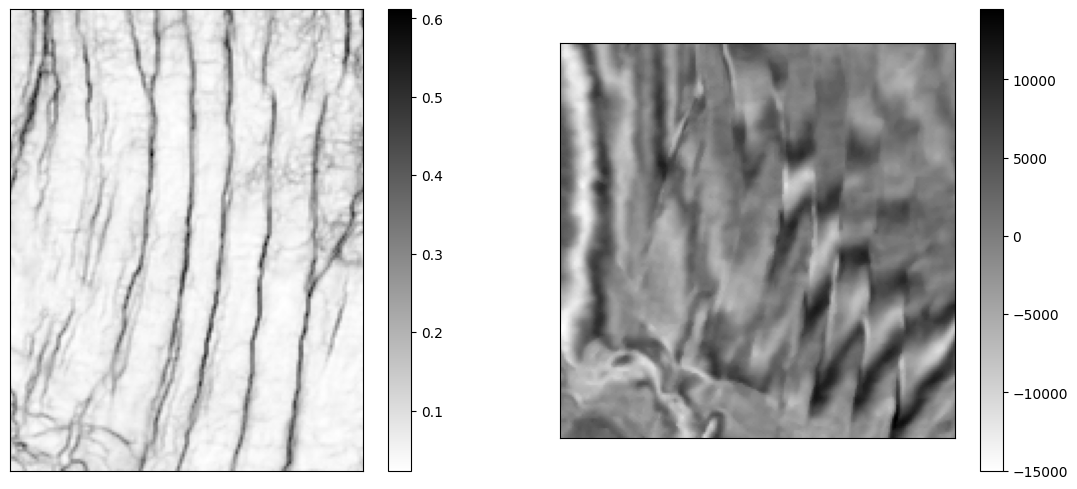

In [ ]:
fig=plt.figure(figsize=(14, 6))
ax=fig.add_subplot(121)
sim=ax.imshow(similarity[:, :, 15], cmap='gray_r');
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

ax1=fig.add_subplot(122)
amp=ax1.imshow(seismic[:, :, 15], cmap='gray_r');
fig.colorbar(amp, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.invert_xaxis()


###NOTE: NB. That does not look right: the amplitude slice is wider than the similarity slice. Based on the filenames, they are supposed to have identical shape! What is going on?

In [ ]:
np.shape(seismic)==np.shape(similarity)

False

In [ ]:
np.shape(seismic)
np.shape(similarity)

(191, 146, 51)

In [ ]:
print('Amplitude IL/XL shape: ' + str(np.shape(seismic)[0]) + ' / ' +str(np.shape(seismic)[1]))

Amplitude IL/XL shape: 201 / 201


In [ ]:
print('Similarity IL/XL shape: ' + str(np.shape(similarity)[0]) + ' / ' +str(np.shape(similarity)[1]))

Similarity IL/XL shape: 191 / 146


In [ ]:
with segyio.open(filename, "r") as segyfile:
    # Print inline and crossline ranges
    print('Amplitude Inline range: ' + str(np.amin(segyfile.ilines)) + ' - ' +str(np.amax(segyfile.ilines)))
    print('Amplitude Crossline range: ' + str(np.amin(segyfile.xlines)) + ' - ' +str(np.amax(segyfile.xlines)))

Amplitude Inline range: 230 - 420
Amplitude Crossline range: 475 - 620


In [ ]:
with segyio.open(filename1, "r") as segyfile:
    # Print inline and crossline ranges
    print('Similarity Inline range: ' + str(np.amin(segyfile.ilines)) + ' - ' +str(np.amax(segyfile.ilines)))
    print('Similarity Crossline range: ' + str(np.amin(segyfile.xlines)) + ' - ' +str(np.amax(segyfile.xlines)))

Similarity Inline range: 230 - 430
Similarity Crossline range: 475 - 675


In [ ]:
seismic = seismic[0:-10:1, 0:-55:1,:]

In [ ]:
assert (np.shape(seismic) == np.shape(similarity))

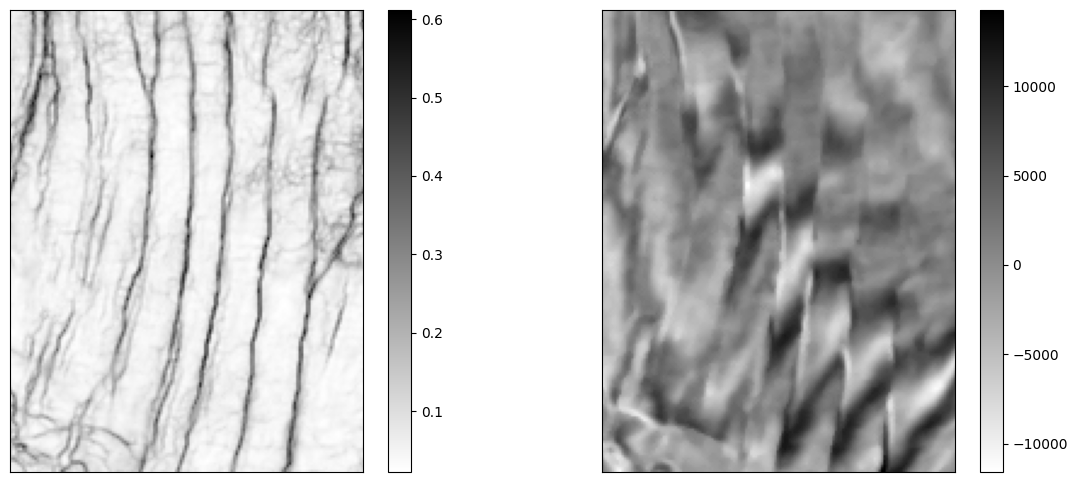

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(121)
sim = ax.imshow(similarity[:,:,15], cmap='gray_r');
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

ax1 = fig.add_subplot(122)
amp = ax1.imshow(seismic[:,:,15], cmap='gray_r');
fig.colorbar(amp, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.invert_xaxis()

###Perfect!!!

Histogram analysis, threshold definition, threshold to make binary fault image
First I calculate the square of the similtarity to stretch its range. This will help with the following hystogram-based thresholding.

In [ ]:
similarity=np.power(similarity, 2)
similarity

array([[[0.05809206, 0.05114017, 0.06413327, ..., 0.00345205,
         0.00334196, 0.00280835],
        [0.11550248, 0.11418156, 0.1663728 , ..., 0.00420268,
         0.00387913, 0.00346804],
        [0.0231435 , 0.02718018, 0.03770083, ..., 0.00246044,
         0.00170071, 0.0015555 ],
        ...,
        [0.00195464, 0.00190169, 0.00178808, ..., 0.04030795,
         0.01916298, 0.01554792],
        [0.00210401, 0.00191456, 0.001754  , ..., 0.04662941,
         0.02132158, 0.01449839],
        [0.00211779, 0.00202782, 0.00209735, ..., 0.03553083,
         0.01981957, 0.01116201]],

       [[0.07632059, 0.06705834, 0.08137222, ..., 0.00720773,
         0.00720589, 0.00688272],
        [0.09719022, 0.08409707, 0.12710503, ..., 0.00553115,
         0.00491456, 0.00554419],
        [0.01829936, 0.02242718, 0.03701307, ..., 0.00242544,
         0.00183868, 0.00203555],
        ...,
        [0.00272   , 0.00203053, 0.00200223, ..., 0.03482293,
         0.01853507, 0.01662294],
        [0.0

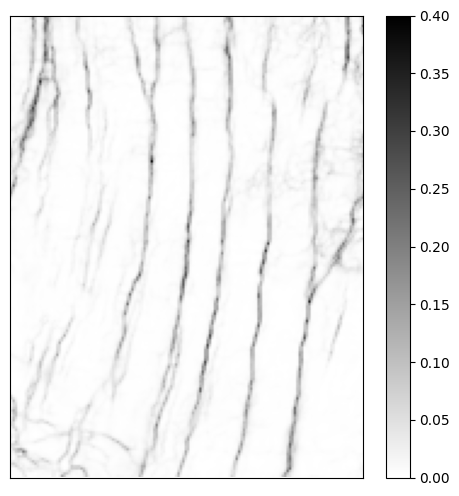

In [ ]:
fig=plt.figure(figsize=(6, 6))

ax=fig.add_subplot(1,1,1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(similarity[:, :, 15], cmap='gray_r', vmin=0, vmax=0.4);
plt.gca().invert_xaxis()
plt.colorbar();


In [ ]:
hi_sim=exposure.histogram(similarity)


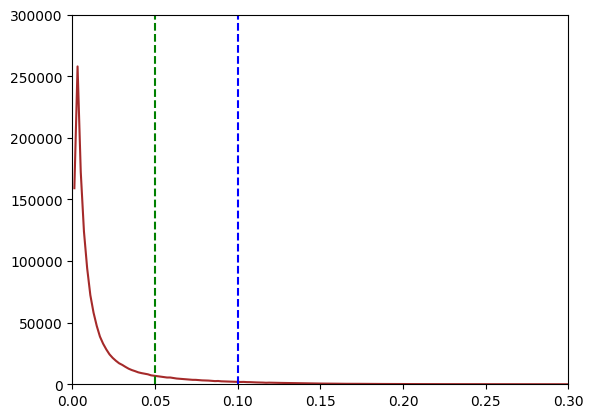

In [ ]:
plt.plot(hi_sim[1], hi_sim[0], 'brown')
plt.ylim(0, 300000)
plt.axvline(0.1, color='b', ls='--')
plt.axvline(0.05, color='g', ls='--')
plt.xlim(0, 0.3);


In [ ]:
binary=np.zeros(similarity.shape, dtype=np.uint8)
binary[similarity> 0.05]=1

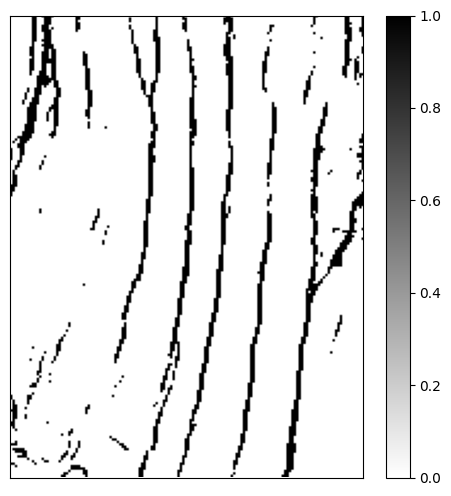

In [ ]:
fig=plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1,1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(binary[:, :, 15], cmap='gray_r');
plt.gca().invert_xaxis()
plt.colorbar();

In [ ]:
label_objects, nb_labels = ndi.label(binary)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 10
mask_sizes[0] = 0
cleaned = mask_sizes[label_objects]*1

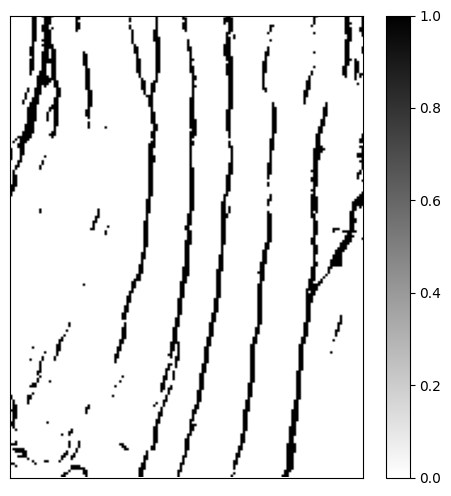

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(cleaned[:,:,15], cmap='gray_r');
plt.gca().invert_xaxis()
plt.colorbar();

In [ ]:
masked = np.zeros((np.shape(cleaned)))
masked[cleaned == 0] = np.nan

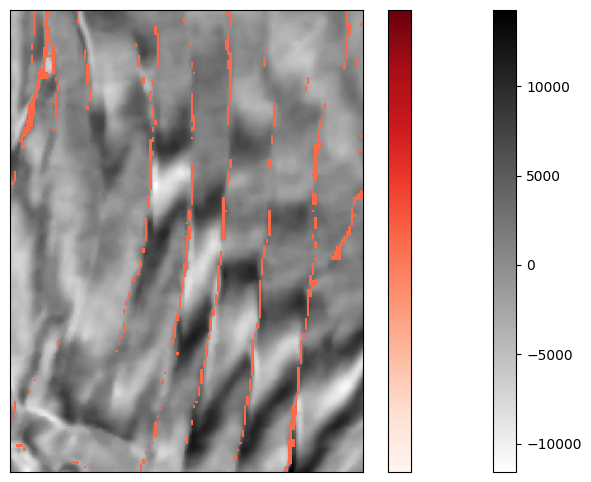

In [ ]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(seismic[:,:,15], cmap='gray_r')
plt.colorbar()

plt.imshow(masked[:,:,15], cmap='Reds')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_ticks([])

###Export fault volume
To export re-using the input header, I make a copy of the input similarity SEGY file, then write to it the cleaned fault array. But first, let's test to ensure inlies are the fast mode. This is important to work with, especially with larger volumes.


In [ ]:
print('Is inline the fast mode? ' + str(segyfile.fast is segyfile.iline))

Is inline the fast mode? True


In [ ]:
dim = np.shape(similarity)
idx = np.arange(0, dim[0])
print(np.amin(idx), np.amax(idx))

lns = np.arange(np.amin(segyfile.ilines), np.amax(segyfile.ilines)+1)
print(np.amin(lns), np.amax(lns))

0 190
230 430


In [ ]:
cleaned = cleaned.astype('float32')

In [ ]:
input_file = '../../data/basic/F3_Similarity_FEF_subvolume_IL230-430_XL475-675_T1600-1800.sgy'
output_file = '../../data/basic/F3_Faults_subvolume_IL230-430_XL475-675_T1600-1800.sgy'
copyfile(input_file, output_file)

with segyio.open(output_file, "r+") as dst:
  for i,j in zip(lns,idx):
    dst.iline[i] = cleaned[j,:,:]

FileNotFoundError: ignored